## Windowed Radon transform to measure image anisotropy

This notebook demonstrates the use of the `windowed_radon` module on a test dataset (anisotropically distributed myosin molecular motors in the _Drosophila_ blastoderm, [Streichan et al., eLife 2018](https://elifesciences.org/articles/27454)).

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import ndimage

from skimage import transform, io

import windowed_radon as wr

from tqdm.notebook import tqdm

In [2]:
# load example image

test_im = io.imread('myosin_example.tif')

We first chose the `size` of the patches on which we will run the Radon transform. Chose this to be comparable to the length of the anisotropic structure you want to detect. The code pre-compute the sparse matrix representing the radon transform for increase speed.

The second set of parameters relates to how peaks/maxima after Radon transform (corresponding to line elements) are detected. You may need to fiddle with this `threshold`. 

In [4]:
# radon transform window size and angular resolution is defined here
# you can ignore the zero-division warning

size = 21  # 31, 19
e_len = int((size-1)/2)

theta = np.linspace(0, 180, 45, endpoint=False)
radon_matrix = wr.get_radon_tf_matrix(size, theta=theta)

# mean threshold removes peaks in radon plane which are < threshold * average line density in patch

threshold = 1.75

In [6]:
# compute the radon transform of the test image
# with the 'return_lines' option, both a list of detected lines and a myosin tensor are returned

lines, m_tensor = wr.windowed_radon(test_im, radon_matrix, theta=theta*np.pi/180, threshold_mean=threshold,
                                    method='global_maximum', return_lines=True)

# merge detected lines from adjacent detection windows
lines = wr.merge_lines(lines, 5)

  0%|          | 0/1117 [00:00<?, ?it/s]

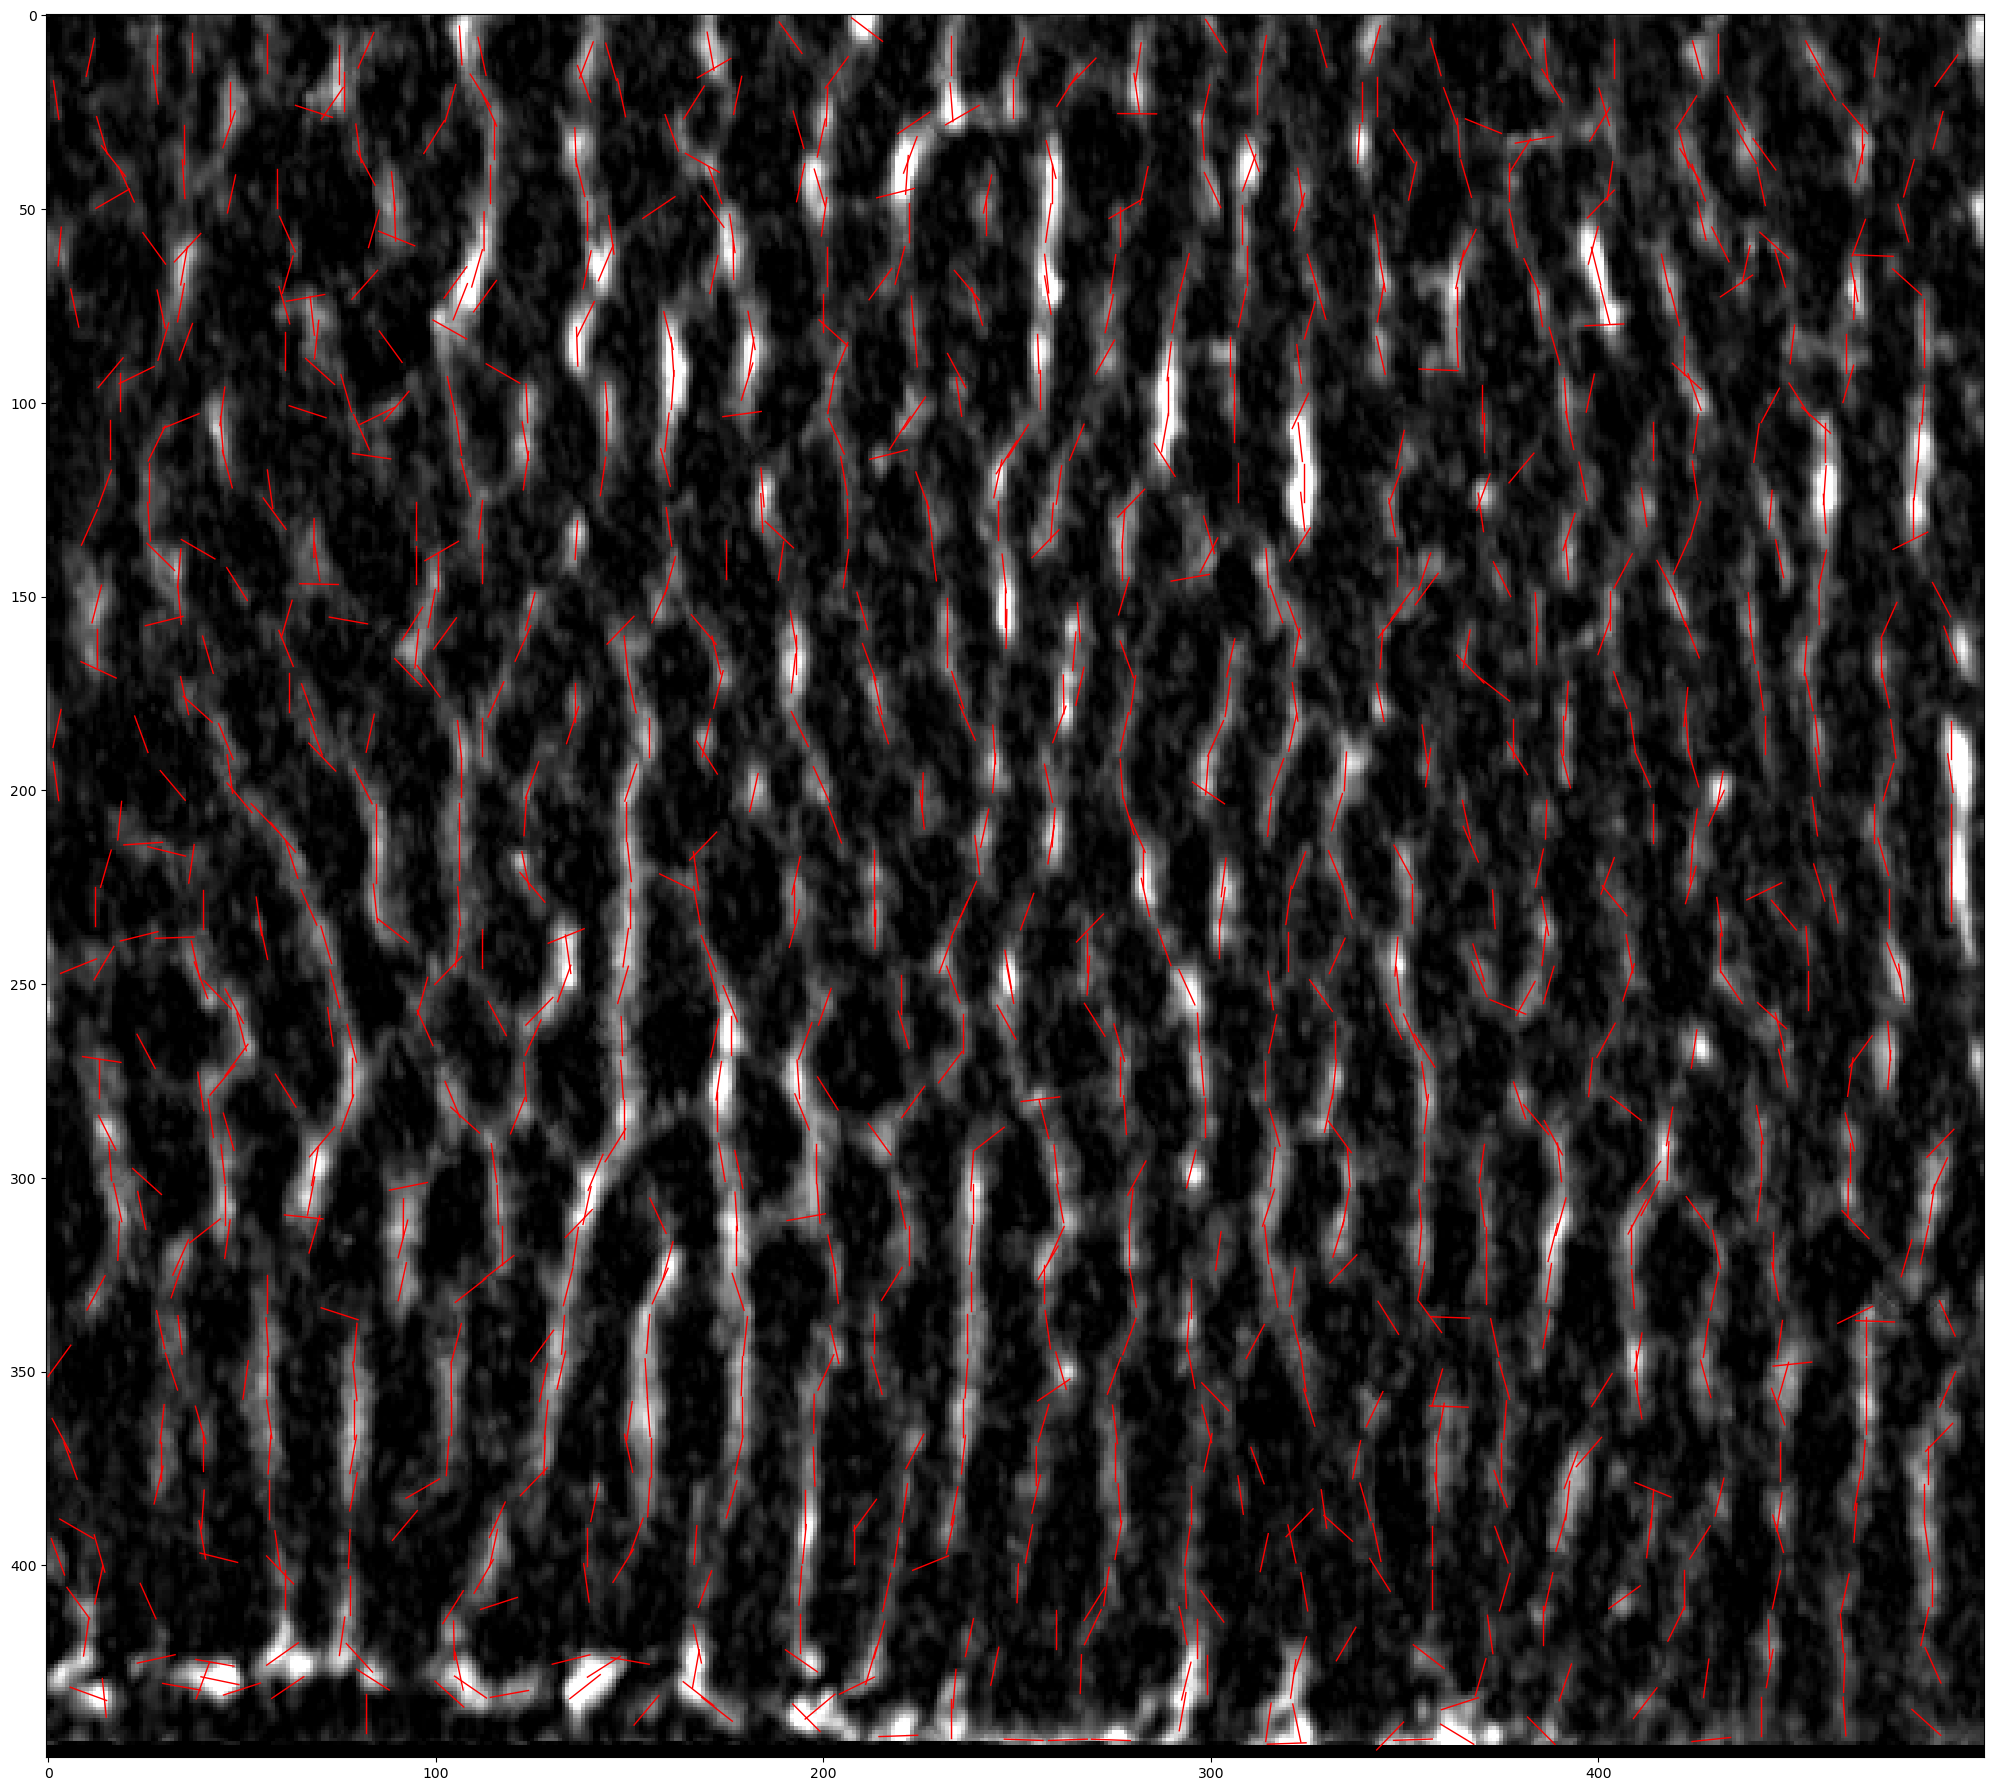

In [7]:
# plot the detected lines over the image for quality check

fig = plt.figure(figsize=(25,25))

plt.imshow(test_im, cmap='gray', vmin=0, vmax=500) #500

length = 5 
for l in tqdm(lines):
    a, b = np.sin(l[1]), np.cos(l[1])
    plt.plot(length*np.array([-a, 0, a])+l[2],
             length*np.array([-b, 0, b])+l[3], color='red', lw=1)


From the detected line elements, we can compute a nematic tensor to measure the smoothed-out anisotropy in the image. The eigenvalues of the nematic tensor `m_tensor` represent anisotropy strength, and the eigenvectors the anisotropy orientation.

In [8]:
# smooth & optionally resize the nematic tensor. Smoothing is required to get a sensible result

sigma_space = 3

m_smooth = wr.filter_field(m_tensor, ndimage.gaussian_filter, kwargs={'sigma': sigma_space})

target_shape = (256, 218)

m_smooth = wr.filter_field(m_smooth, transform.resize, kwargs={'output_shape': target_shape})

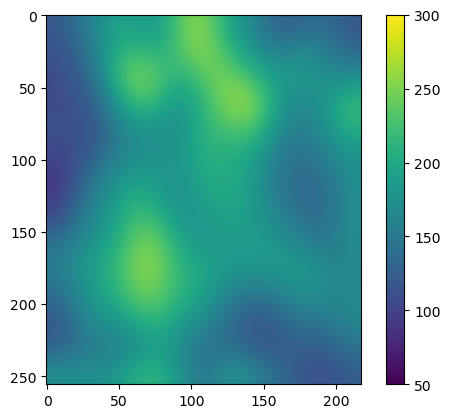

In [9]:
# plot the norm

norm_test = np.linalg.norm(m_smooth, axis=(-2, -1))
plt.imshow(norm_test, vmin=50, vmax=300)
plt.colorbar()
plt.show()

In [ ]:
# save the computed tensor

np.save('test_tensor.npy', m_smooth)